# XGB Regression for predicting SNP 500

## Goal:
    - Want to outperform the SNP. Well for the days when we buy, we want to outperform the SNP.

## Data 
    - All the basic metrics other than RSI200. When using it, the model will fail to detect the 08 crash.
    - Y 7 days out. This is a week and a half out. (10, 20, 60, 120) days out were tested but were worse.
    - It appeared that removing datapoints with y close to the mean improved the model, yet after running experiments, it did not.

## Evals
    - The basic model was evaluated by using 5fold cross validation, observing the RMSE, and correlation between the predicted and actual values.
    - The predictions were then used to detect when to hold and when to sell. A threshold using the 70th percentile of train predictions was used. If the predictions were above that threshold, then we hold the stock for 7 days.
    - The baseline of using 1.08 increase was used, as it would be for margin trading.
    - The same comparison was used for the test data.



In [87]:
#Download SNP500 data from 1973 to 2023
#use Yahoo Finance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta


In [88]:
pred_preiod = 7
dist = 0

In [89]:
import yfinance as yf

# Download data for the S&P 500 index from 2020 to 2022
ticker = "SPY"
start_date = "1973-01-01"
end_date = "2023-05-01"
sp500_data = yf.download(ticker, start=start_date, end=end_date)

# Print the first 5 rows of the data
print(sp500_data.head())

[*********************100%***********************]  1 of 1 completed
                Open      High       Low     Close  Adj Close   Volume
Date                                                                  
1993-01-29  43.96875  43.96875  43.75000  43.93750  25.122347  1003200
1993-02-01  43.96875  44.25000  43.96875  44.25000  25.301010   480500
1993-02-02  44.21875  44.37500  44.12500  44.34375  25.354637   201300
1993-02-03  44.40625  44.84375  44.37500  44.81250  25.622652   529400
1993-02-04  44.96875  45.09375  44.46875  45.00000  25.729845   531500


In [86]:

# Download data for the S&P 500 index from 2020 to 2022
ticker = "SPY"
start_date = "2023-05-23"
end_date = "2023-05-27"
sp500_data = yf.download(ticker, start=start_date, end=end_date)

# Print the first 5 rows of the data
print(sp500_data.head())

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close   
Date                                                                     
2023-05-23  417.079987  418.720001  413.679993  414.089996  414.089996  \
2023-05-24  412.420013  412.820007  409.880005  411.089996  411.089996   
2023-05-25  414.739990  416.160004  412.410004  414.649994  414.649994   

              Volume  
Date                  
2023-05-23  86383500  
2023-05-24  89213700  
2023-05-25  90872800  


<Axes: xlabel='Date'>

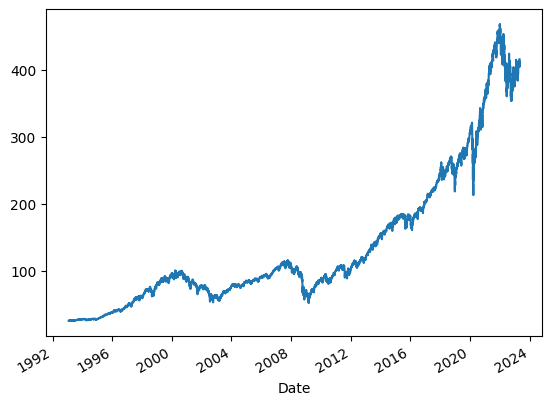

In [4]:
# Plot the adjusted close price
sp500_data["Adj Close"].plot()

In [5]:
#get percent growth from start to end
start_price = sp500_data["Adj Close"][0]
end_price = sp500_data["Adj Close"][-1]
percent_growth = (end_price-start_price)/start_price
print(percent_growth)

15.556177106907237


In [6]:
dataset = pd.DataFrame(sp500_data["Adj Close"])

In [7]:
#get the most important technical indicators
ma_50 = sp500_data["Adj Close"].rolling(window=50).mean()
ma_200 = sp500_data["Adj Close"].rolling(window=200).mean()
ema_50 = sp500_data["Adj Close"].ewm(span=50, adjust=False).mean()
ema_200 = sp500_data["Adj Close"].ewm(span=200, adjust=False).mean()

#get the RSI (relative strength index)
#RSI = 100 - 100/(1 + RS)
rsi = ta.momentum.RSIIndicator(sp500_data["Adj Close"], window=14).rsi()

# Download VIX data from Yahoo Finance
vix = yf.download('^VIX', start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed


In [8]:
dataset['ma_50'] = ma_50
dataset['ma_200'] = ma_200
dataset['ema_50'] = ema_50
dataset['ema_200'] = ema_200
dataset['rsi'] = rsi

<Axes: xlabel='Date'>

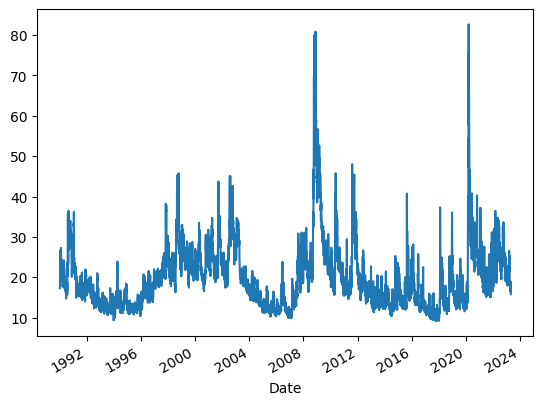

In [9]:
#plot vix
vix["Adj Close"].plot()

In [10]:
#GDP growth, inflation rates, and employment data
import pandas_datareader.data as web


In [11]:
gdp = web.DataReader('GDPC1', 'fred', start_date, end_date)
inflation = web.DataReader('CPIAUCSL', 'fred', start_date, end_date)
unemployment = web.DataReader('UNRATE', 'fred', start_date, end_date)

In [12]:
#convert inflation to inflatin rate
inflation_rate = inflation.pct_change()
#add smoothed inflation rate
inflation_rate['inflation_rate_12m'] = inflation_rate['CPIAUCSL'].rolling(window=12).mean()

In [13]:
dataset['daily_returns'] = sp500_data["Adj Close"].pct_change().shift(-1)

<Axes: xlabel='DATE'>

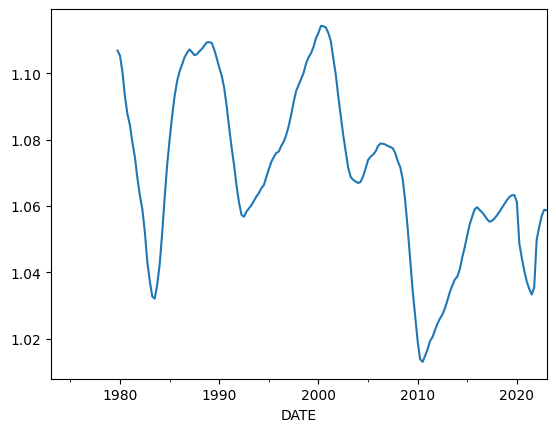

In [14]:
#calculate moving average of GDP
gdp['gdp_7m'] = gdp['GDPC1'].rolling(window=7).mean()
gdp['gdp_28m'] = gdp['GDPC1'].rolling(window=28).mean()
gdp['gdp_ratio'] = (gdp['gdp_7m']/gdp['gdp_28m'])
#plot gdp
gdp['gdp_ratio'].plot()

In [15]:
dataset['gdp_ratio'] = gdp['gdp_ratio']
dataset['unemployment'] = unemployment['UNRATE']
dataset['inflation_rate'] = inflation_rate['inflation_rate_12m']


In [16]:
# merge dataset and gdp on Date and DATE 

The Put call ratio should be a good indicator, yet it is recent, and may not be available into the 1970s

<Axes: xlabel='DATE'>

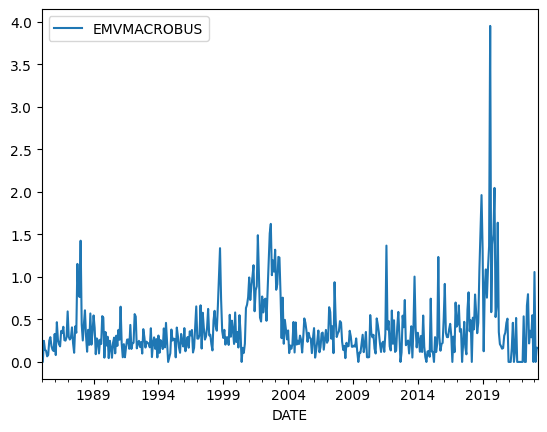

In [17]:
#investor Intelligence Sentiment Index
consumer_sentimet = web.DataReader('UMCSENT', 'fred', start_date, end_date)
equity_volatility = web.DataReader('EMVMACROBUS', 'fred', start_date, end_date)
#plot iis
equity_volatility.plot()

In [18]:
dataset['consumer_sentimet'] = consumer_sentimet['UMCSENT']
dataset['equity_volatility'] = equity_volatility['EMVMACROBUS']

In [19]:
#get the columns
print(dataset.columns)

Index(['Adj Close', 'ma_50', 'ma_200', 'ema_50', 'ema_200', 'rsi',
       'daily_returns', 'gdp_ratio', 'unemployment', 'inflation_rate',
       'consumer_sentimet', 'equity_volatility'],
      dtype='object')


In [20]:
dataset.columns

Index(['Adj Close', 'ma_50', 'ma_200', 'ema_50', 'ema_200', 'rsi',
       'daily_returns', 'gdp_ratio', 'unemployment', 'inflation_rate',
       'consumer_sentimet', 'equity_volatility'],
      dtype='object')

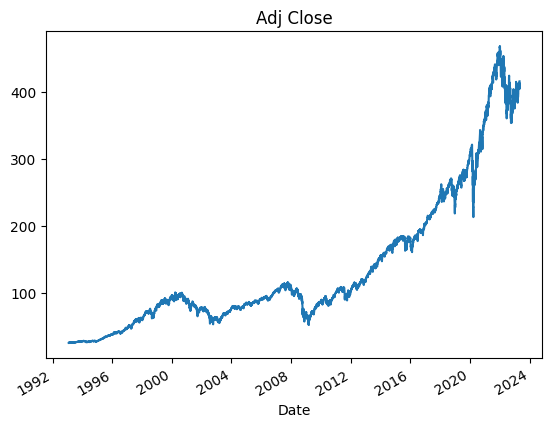

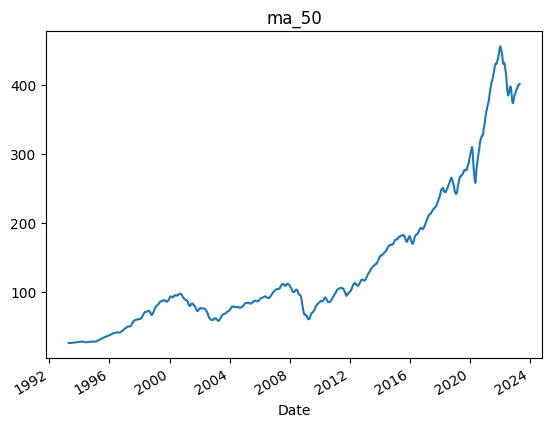

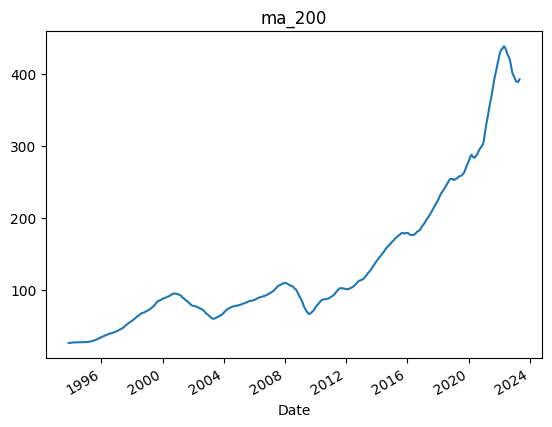

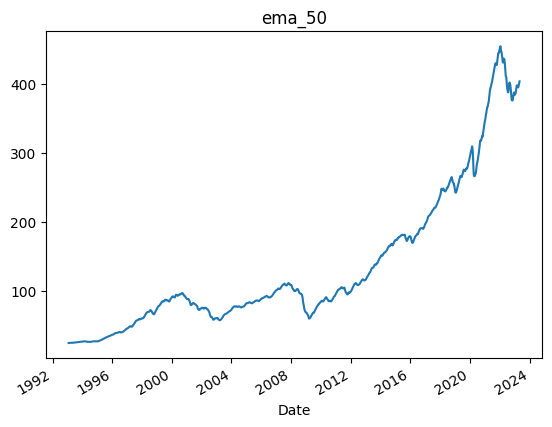

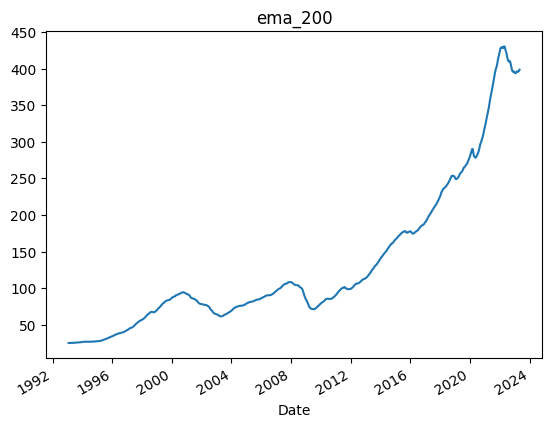

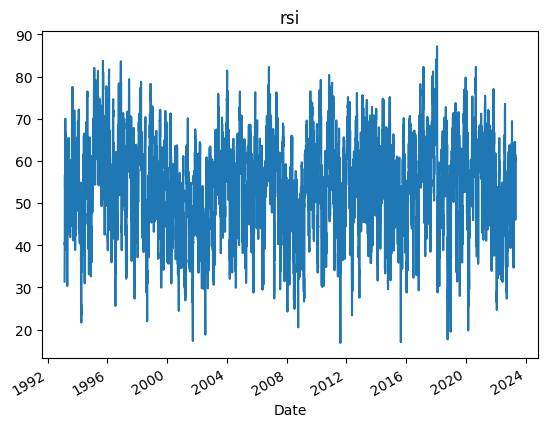

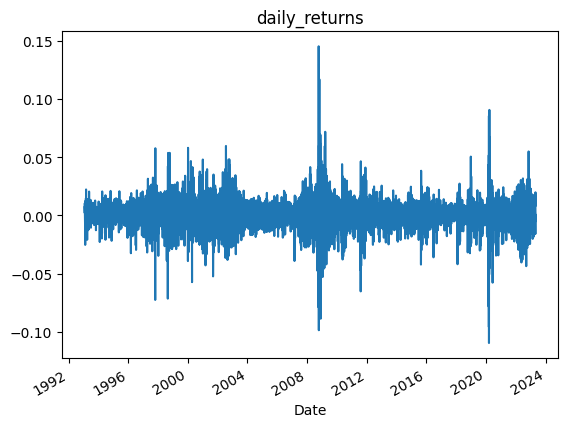

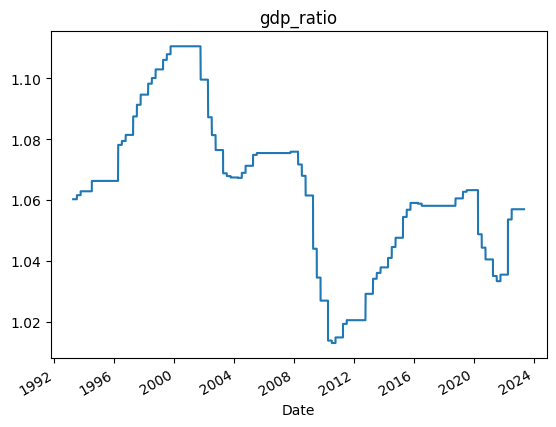

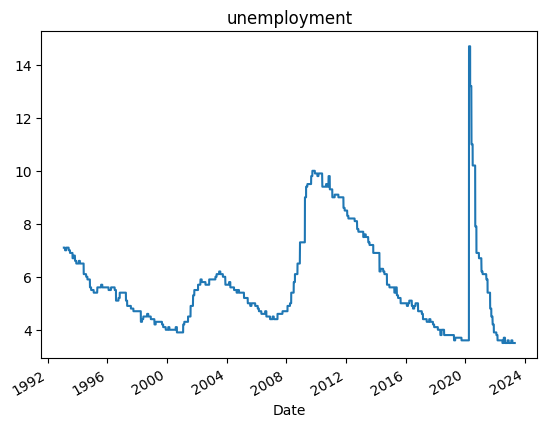

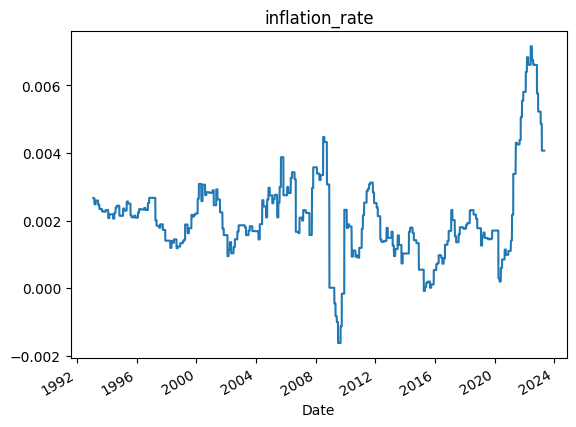

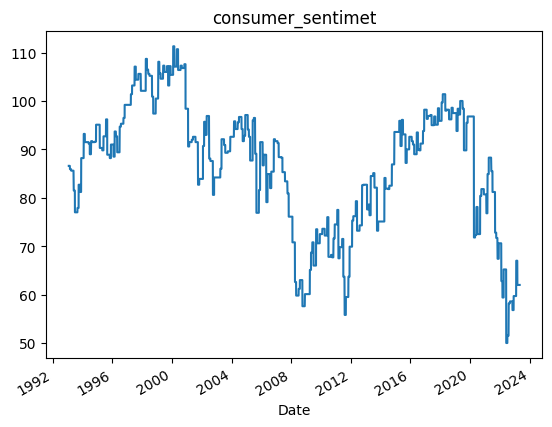

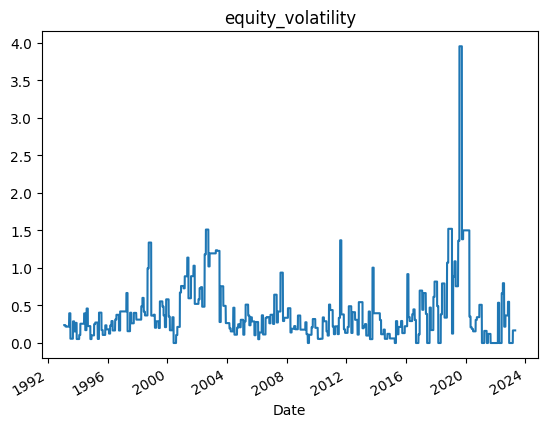

In [21]:
#plot the data for each column
for column in dataset.columns:
    dataset[column].fillna(method='ffill').plot()
    plt.title(column)
    plt.show()

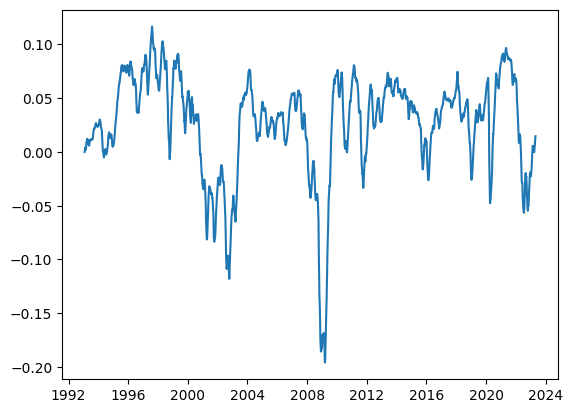

In [22]:
#ema50 - ema200
dataset['norm_ema_ratio'] = (dataset['ema_50'] - dataset['ema_200'])/dataset['ema_200']
plt.plot(dataset['norm_ema_ratio'])

# Create a new column that identifies when the EMAs cross over each other
dataset["EMA_crossover"] = ((dataset['norm_ema_ratio'].shift(1) < 0) & (dataset['norm_ema_ratio'] > 0)).astype(int)


In [23]:
#rsa moving average
dataset['rsi_ma_50'] = dataset['rsi'].rolling(window=50).mean()
dataset['rsi_ma_200'] = dataset['rsi'].rolling(window=200).mean()

In [24]:
dataset['Adj Close'].shift(1)

Date
1993-01-29           NaN
1993-02-01     25.122345
1993-02-02     25.301022
1993-02-03     25.354628
1993-02-04     25.622648
                 ...    
2023-04-24    412.200012
2023-04-25    412.630005
2023-04-26    406.079987
2023-04-27    404.359985
2023-04-28    412.410004
Name: Adj Close, Length: 7617, dtype: float64

In [25]:
# Calculate the rolling mean over a window of thirty days
rolling_mean = dataset['Adj Close'].rolling(window=120).mean()
dataset['percent_increase_smooth'] = (dataset['Adj Close'].shift(-1*pred_preiod) - rolling_mean) / rolling_mean * 100

<Axes: xlabel='Date'>

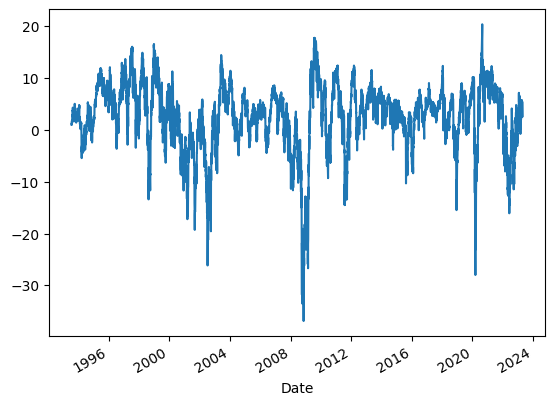

In [26]:
#plot percent increase smooth
dataset['percent_increase_smooth'].plot()

In [27]:
print(dataset.columns)
cols_to_model = ['norm_ema_ratio',  'gdp_ratio', 'EMA_crossover', 'rsi', 
       'unemployment', 'consumer_sentimet','inflation_rate',
       'equity_volatility', 'rsi_ma_50']
       #'rsi_ma_200']
#percent_inc = (dataset['Adj Close'].shift(-1)/dataset['Adj Close'] - 1)
#find the percent increase over the next 30 days
percent_inc_30 = dataset['percent_increase_smooth']
#percent_inc = (dataset['Adj Close'].shift(-7) / dataset['Adj Close'] - 1) * 100 / 7
y = percent_inc_30.shift(-1)
dataset['pct_growth'] = y
dataset = dataset[:-31]

Index(['Adj Close', 'ma_50', 'ma_200', 'ema_50', 'ema_200', 'rsi',
       'daily_returns', 'gdp_ratio', 'unemployment', 'inflation_rate',
       'consumer_sentimet', 'equity_volatility', 'norm_ema_ratio',
       'EMA_crossover', 'rsi_ma_50', 'rsi_ma_200', 'percent_increase_smooth'],
      dtype='object')


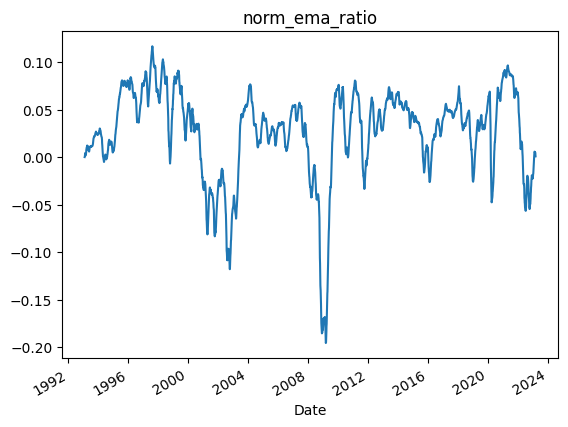

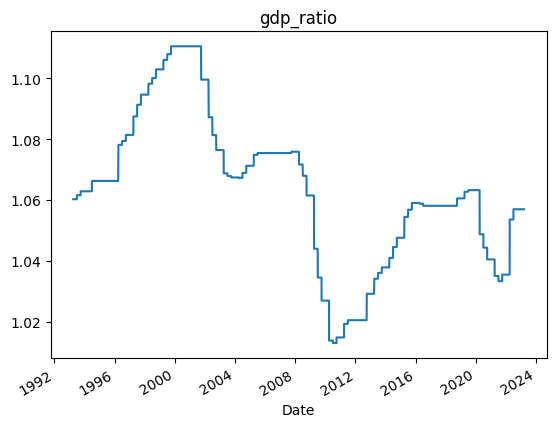

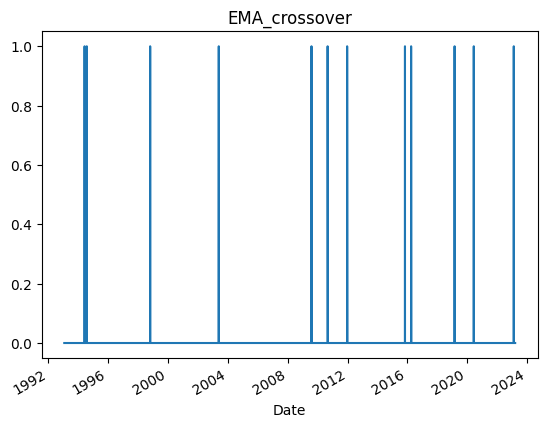

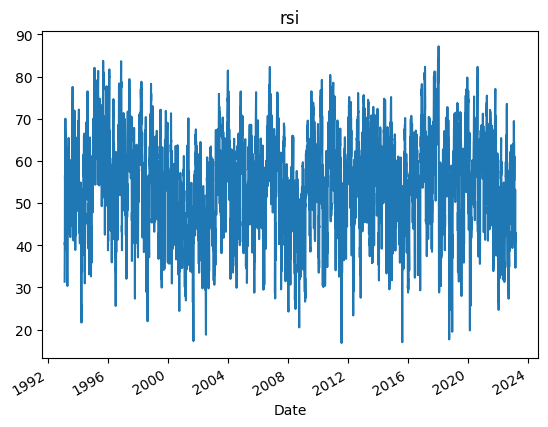

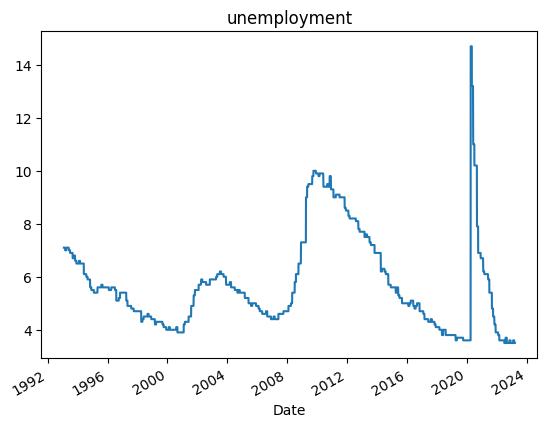

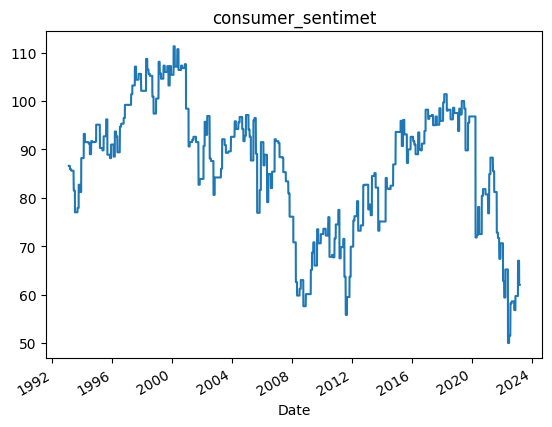

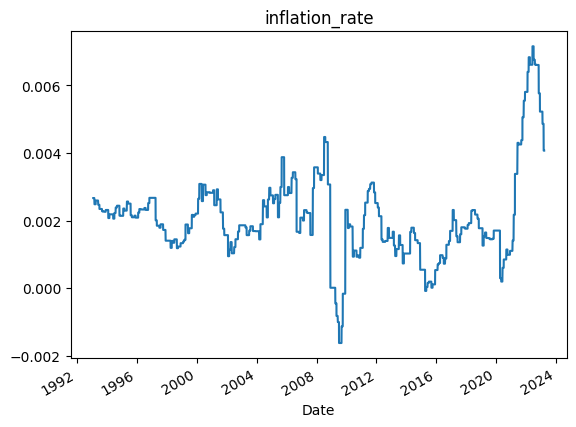

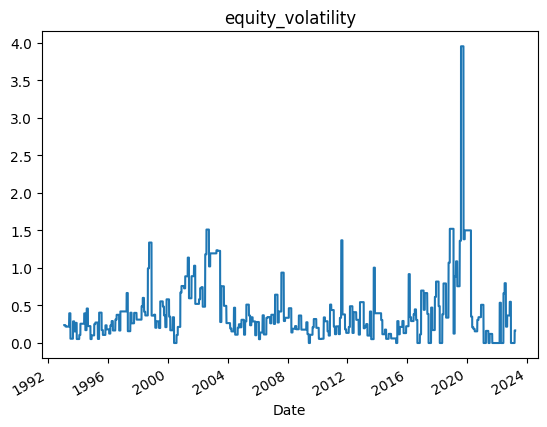

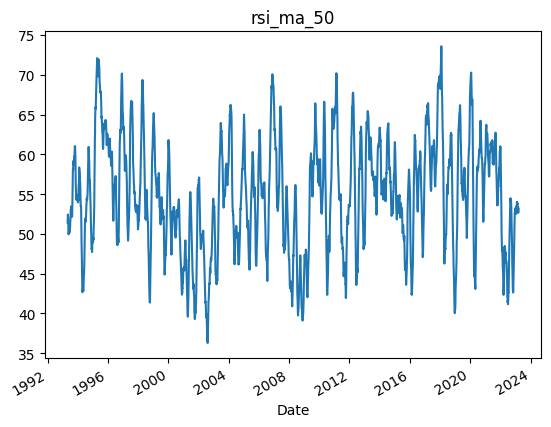

In [28]:

for column in cols_to_model:
    dataset[column].fillna(method='ffill').plot()
    plt.title(column)
    plt.show()

In [29]:
dataset['pct_growth'].median()

3.4723317506646483

In [30]:
#get num na values in dataset['pct_growth']
dataset['pct_growth'].isna().sum()
dataset['y'] = .5
dataset.loc[dataset['pct_growth'] > dataset['pct_growth'].median(), 'y'] = 1
dataset.loc[dataset['pct_growth'] < dataset['pct_growth'].median(), 'y'] = 0
dataset['y'] = dataset['pct_growth']

In [31]:
#get number of 1s and 0s
dataset['y'].value_counts()


y
1.016590     1
7.306952     1
11.586291    1
10.684043    1
11.367182    1
            ..
13.237274    1
12.116532    1
11.053132    1
12.234802    1
2.350199     1
Name: count, Length: 7468, dtype: int64

In [32]:
X = dataset[cols_to_model].fillna(method='ffill')
y = dataset['y']
pct_change =  dataset['pct_growth']

In [33]:
#get nan values in X
X.isna().sum()

norm_ema_ratio        0
gdp_ratio            43
EMA_crossover         0
rsi                  13
unemployment          1
consumer_sentimet     1
inflation_rate        1
equity_volatility     1
rsi_ma_50            62
dtype: int64

In [34]:
X = X[212:]
y = y[212:]
dates = dataset.index[212:]
pct_change = pct_change[212:]
pct_returns = dataset['daily_returns'][212:]

In [35]:
len(X)

7374

In [36]:
len(dates)

7374

In [37]:
#get nan values in X
X.isna().sum()

norm_ema_ratio       0
gdp_ratio            0
EMA_crossover        0
rsi                  0
unemployment         0
consumer_sentimet    0
inflation_rate       0
equity_volatility    0
rsi_ma_50            0
dtype: int64

In [38]:
#drop values where y is 0
# X = X[y != .5]
# pct_change = pct_change[y != .5]
# dates = dates[y != .5]
# y = y[y != .5]


In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

scaler = StandardScaler()

seed = 42

kf = KFold(n_splits=5, shuffle=False)

#split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=False)
# # Fit the scaler to your data to calculate the mean and standard deviation

scaler.fit(X_train)

#get nan values in dataset
print(X_train.isna().sum())

# # Apply the scaler to your data to transform it to a normalized form
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


norm_ema_ratio       0
gdp_ratio            0
EMA_crossover        0
rsi                  0
unemployment         0
consumer_sentimet    0
inflation_rate       0
equity_volatility    0
rsi_ma_50            0
dtype: int64


In [40]:
# #seperate the data into 
# #split the training into 5 fold cross validation
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import KFold
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression

# scaler = StandardScaler()

# seed = 42

# kf = KFold(n_splits=5, shuffle=False)

# #split the data into training and testing
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=False)
# # # Fit the scaler to your data to calculate the mean and standard deviation

# scaler.fit(X_train)

# #get nan values in dataset
# print(X_train.isna().sum())

# # # Apply the scaler to your data to transform it to a normalized form
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# #count number of nan values in X_train_scaled
# print(np.isinf(X_train_scaled).sum())

# #split train into 5 fold cross validation
# kf = KFold(n_splits=5, shuffle=False)

# scores = []
# correlations = []
# preds = []
# gt = []
# for train_idx, val_idx in kf.split(X_train_scaled):
#     # split the data into training and validation sets for this fold
#     train_X, val_X = X_train_scaled[train_idx], X_train_scaled[val_idx]
#     train_y, val_y = y_train[train_idx], y_train[val_idx]

#     pct_change_train, pct_change_val = pct_change[train_idx], pct_change[val_idx]
#     #trainX and Y where percent_change < 0 or > 10

#     train_X = train_X[(pct_change_train < median-dist) | (pct_change_train > median+dist)]
#     train_y = train_y[(pct_change_train < median-dist) | (pct_change_train > median+dist)]

#     #count number of nan values in X_train_scaled
#     print(np.isnan(train_y).sum())

#     # fit the model for this fold
#     model = LinearRegression()
#     model.fit(train_X, train_y)

#     #predict for this fold
#     pred = model.predict(val_X)
#     preds.append(pred)
#     gt.append(val_y)

#     #calculate rmse for this fold
#     rmse = np.sqrt(np.mean((model.predict(val_X) - val_y) ** 2))
#     scores.append(rmse)

#     #calculate correlation for this fold
#     corr = np.corrcoef(model.predict(val_X), val_y)[0, 1]
#     correlations.append(corr)

# print(scores)
# print(correlations)

In [41]:
# for train_idx, val_idx in kf.split(X_train_scaled):
#     min_val_idx = min(val_idx)
#     max_val_idx = max(val_idx)
#     train_idx = [i for i in train_idx if i < min_val_idx-30 and i > max_val_idx]

In [42]:
len(y)

7374

In [43]:
#create use XGBoost model for regression
import xgboost as xgb
from sklearn.metrics import mean_squared_error

scaler = StandardScaler()

seed = 42

kf = KFold(n_splits=5, shuffle=False)

#split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=False)

# # Fit the scaler to your data to calculate the mean and standard deviation
scaler.fit(X_train)

#get nan values in dataset
print(X_train.isna().sum())

# # Apply the scaler to your data to transform it to a normalized form
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)



norm_ema_ratio       0
gdp_ratio            0
EMA_crossover        0
rsi                  0
unemployment         0
consumer_sentimet    0
inflation_rate       0
equity_volatility    0
rsi_ma_50            0
dtype: int64


<Axes: >

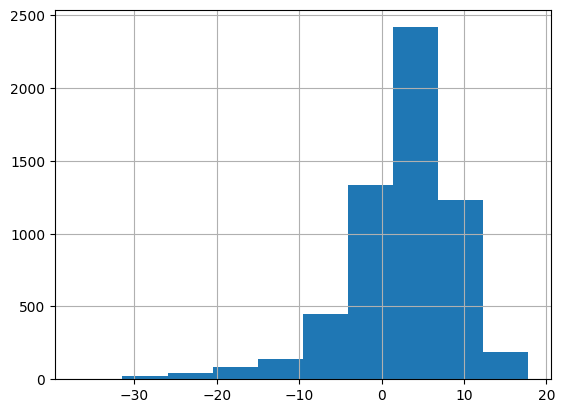

In [44]:
y_train.hist()

In [45]:
#remove values that don't matter much
mean_dist = np.mean(y_train)
print(mean_dist)

2.478432386103935


In [46]:
len(y_train)

5899

In [47]:
X_train_scaled.shape

(5899, 9)

In [48]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_distributions = {
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'max_depth': [1, 2, 3, 5, 7, 9, 13],
    'n_estimators': [1,2, 3, 5,10, 50, 100],
    'alpha': [0, 1, 10, 100, 1000],
    'colsample_bytree': [0.3, 0.5, 0.7, .9]
}

#y_train = np.where(y_train < 0, y_train, y_train)
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_cv = RandomizedSearchCV(xgb_reg, param_distributions, cv=kf, n_iter=1000, random_state=42, n_jobs=-1)


trn_idxs = (y_train < mean_dist-dist) | (y_train > mean_dist+dist)
X_train_scaled_extreme, train_y_extreme = X_train_scaled[trn_idxs], y_train[trn_idxs]
xgb_cv.fit(X_train_scaled_extreme, train_y_extreme)

print(xgb_cv.best_params_)

# xgb_model = xgb.XGBRegressor(**xgb_cv.best_params_)
# xgb_model.fit(X_train_scaled, y_train)

# # Evaluate on test set
# test_pred = xgb_model.predict(X_test_scaled)
# test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
# test_corr = np.corrcoef(test_pred, y_test)[0, 1]

# print('Test RMSE:', test_rmse)
# print('Test correlation:', test_corr)

{'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.7, 'alpha': 1}


In [49]:
configs = xgb_cv.best_params_

train_scores = []
scores = []
correlations = []
preds = []
gt = []
for train_idx, val_idx in kf.split(X_train_scaled):

    min_val_idx = min(val_idx)
    max_val_idx = max(val_idx)
    train_idx = [i for i in train_idx if i < min_val_idx-pred_preiod or i > max_val_idx]

    # split the data into training and validation sets for this fold
    train_X, val_X = X_train_scaled[train_idx], X_train_scaled[val_idx]
    train_y, val_y = y_train[train_idx], y_train[val_idx]
    #add more weight to values < 0

    #trainX and Y where percent_change < 0 or > 10
    trn_idxs = (train_y < mean_dist-dist) | (train_y > mean_dist+dist)
    train_X, train_y = train_X[trn_idxs], train_y[trn_idxs]
    
    #load xgb model from config
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', **configs)

    xgb_model.fit(train_X, train_y)

    #predict for this fold
    pred = xgb_model.predict(val_X)
    preds.append(pred)
    gt.append(val_y)

    train_rmse = np.sqrt(mean_squared_error(train_y, xgb_model.predict(train_X)))
    train_scores.append(train_rmse)

    #calculate rmse for this fold
    rmse = np.sqrt(np.mean((xgb_model.predict(val_X) - val_y) ** 2))
    scores.append(rmse)

    #calculate correlation for this fold
    corr = np.corrcoef(xgb_model.predict(val_X), val_y)[0, 1]
    correlations.append(corr)

print(train_scores)
print(scores)
print(correlations)

[3.0207525440131318, 2.5745725068797984, 3.0628446707563466, 2.522528885994675, 3.0549002066073148]
[3.0132422996045416, 4.727260919632512, 2.542877010838038, 6.596233542418142, 2.9858961946528315]
[0.7602532116270311, 0.8050672546032805, 0.7264371513777435, 0.8330558210122837, 0.7049256270331716]


In [50]:
exp_preds = np.concatenate(preds)
pct_returns_train = pct_returns[:int(len(pct_change)*.8)]

In [51]:
#here's the backtesting strategy
#If the model predicts a positive return, long the SNP500, if it falls below zero then short the SNP500
#Even though the predictions are a month away, this is a good way to backtest the model

In [52]:
# from sklearn.metrics import roc_auc_score
# #calculate the correlation between the predictions and the actual values
# corr = np.corrcoef(exp_preds, gt)[0, 1]
# print(corr)
#roc_score = roc_auc_score(gt, exp_preds)
# roc_score = roc_auc_score(y_train, exp_preds)
# print(roc_score)

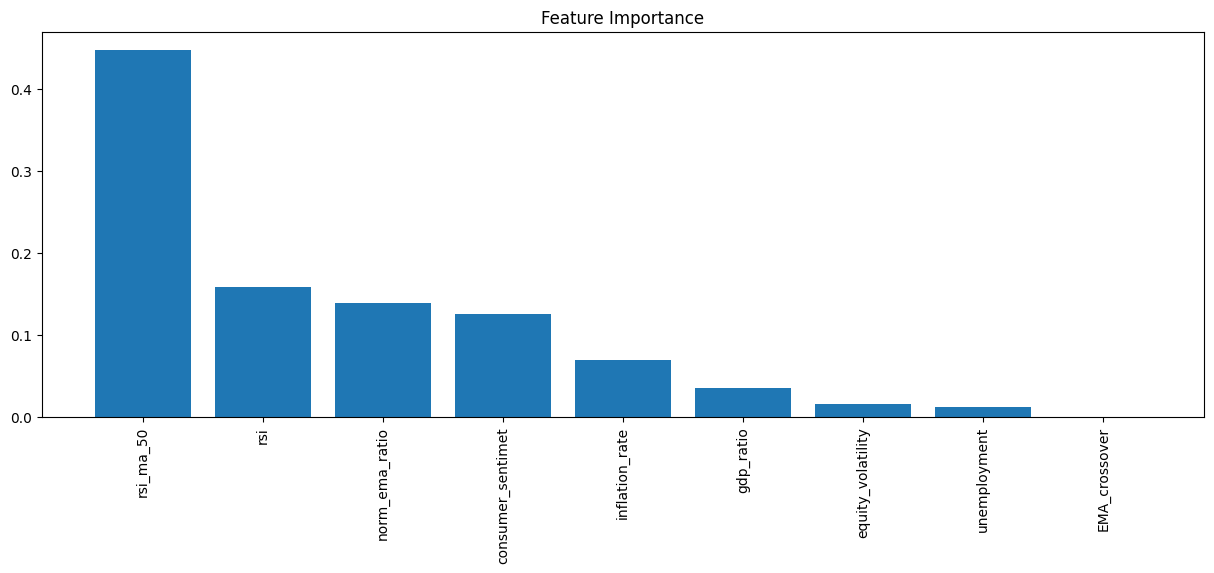

In [53]:
#find the most important features in the model
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X_train.columns[i] for i in indices]

#plot the most important features
plt.figure(figsize=(15, 5))
plt.title("Feature Importance")
plt.bar(range(X_train_scaled.shape[1]), importances[indices])
plt.xticks(range(X_train_scaled.shape[1]), names, rotation=90)
plt.show()

In [54]:
len(dates[:int(.8*len(dates))])

5899

In [55]:
len(y_train)

5899

Text(0.5, -0.11, 'Predictions from basic xgboost logistic regression. Y is increase in price in 2 months over current avg. \nFor training, it is filtered to remove avg points. The overall AUC score is .55. \n Please see the code in cache_notebooks/snp500_xgboost_classification.ipynb')

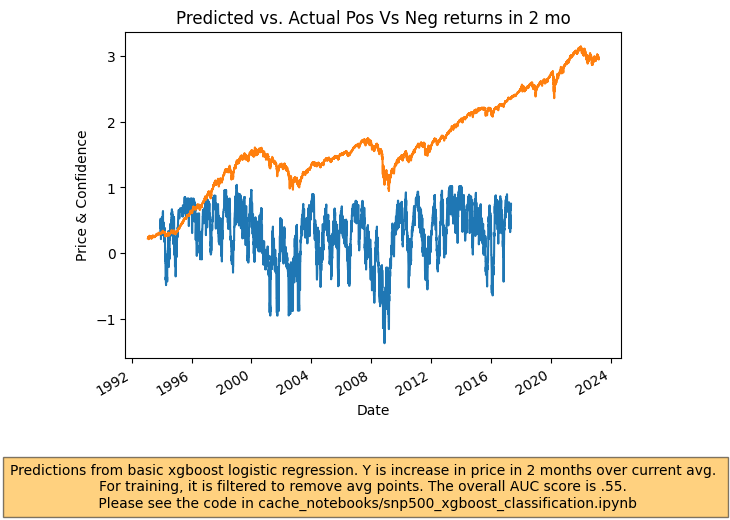

In [57]:
#plot exp_preds as a function of time
plt.plot(dates[:int(.8*len(dates))],exp_preds/10)
#plot dataset with adjusted close
#dataset['Adj Close'].plot()
#plot the log of the adjusted close
(np.log(dataset['Adj Close'])-3).plot()
plt.title('Predicted vs. Actual Pos Vs Neg returns in 2 mo')
plt.xlabel('Date')
plt.ylabel('Price & Confidence')
#add caption below plot
text = "Predictions from basic xgboost logistic regression. Y is increase in price in 2 months over current avg. \n"+\
        "For training, it is filtered to remove avg points. The overall AUC score is .55. \n Please see the code in cache_notebooks/snp500_xgboost_classification.ipynb"
plt.figtext(0.5, -0.11, text, ha='center', fontsize=10, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

#save plot to cache_notebooks/snp500_xgboost_classification.ipynb
#plt.savefig('../graph_results/snp500_xgboost_classification.png', bbox_inches='tight')

In [58]:
np.mean(exp_preds)
#get the 90th percentile of the predictions
np.percentile(exp_preds, 70)

5.862155914306641

In [59]:
threshold = np.percentile(exp_preds, 70)

In [70]:
dates_in_pos_mo = []
for i in dates[:int(.8*len(dates))][exp_preds > threshold]:
    for j in pd.date_range(i, periods=60, freq='D'):
        if (j not in dates_in_pos_mo):
            dates_in_pos_mo.append(j)
dates_in_pos_mo = [i for i in dates_in_pos_mo if i in dates[:int(.8*len(dates))]]
#make dates_in_pos_mo unique
dates_in_pos_mo = sorted(list(set(dates_in_pos_mo)))

In [71]:
len(dates_in_pos_mo)/252

13.654761904761905

In [72]:
dates.isin(dates_in_pos_mo)

array([False, False, False, ..., False, False, False])

In [73]:
train_dates = dates[:int(.8*len(dates))]

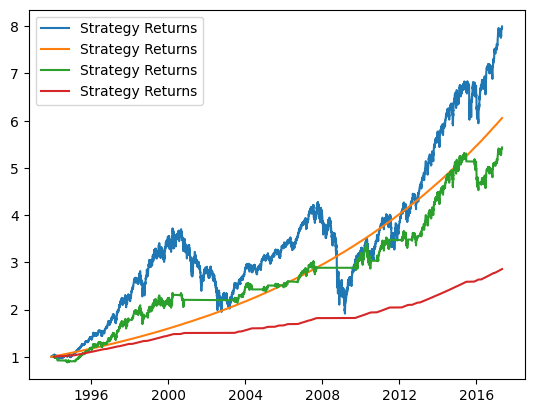

In [74]:
#plot the strategy returns and pct_returns
plt.plot(train_dates, (1+pct_returns_train).cumprod(), label='Strategy Returns')
plt.plot(train_dates, np.array(([1.0003054] * len(dates[:int(.8*len(dates))]))).cumprod(), label='Strategy Returns')
plt.plot(dates_in_pos_mo, (1+pct_returns_train[train_dates.isin(dates_in_pos_mo)]).cumprod(), label='Strategy Returns')
plt.plot(dates_in_pos_mo, np.array(([1.0003054] * len(dates_in_pos_mo))).cumprod(), label='Strategy Returns')

#plt.plot(dates[:int(.8*len(dates))], (1+np.array(pct_returns)).cumprod(), label='S&P500 Returns')
plt.legend()

Looking at the test data

In [75]:
test_dates = dates[int(.8*len(dates)):]
test_pred = xgb_model.predict(X_test_scaled)

0.7117368032224224


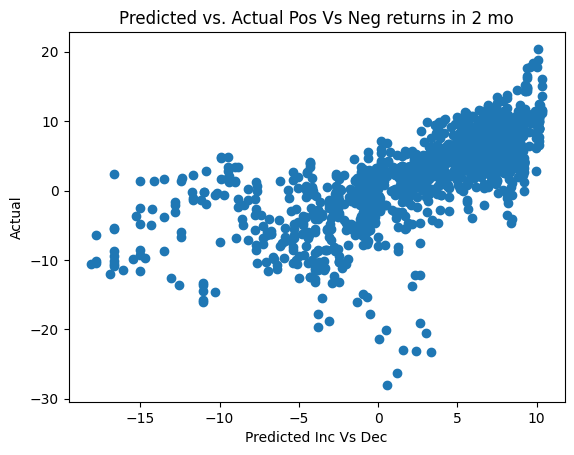

In [76]:

gt = pct_change[:int(len(pct_change)*.8)]
gt_test = pct_change[int(len(pct_change)*.8):]
pct_returns_test = pct_returns[int(len(pct_change)*.8):]

plt.scatter(test_pred, gt_test)
plt.title('Predicted vs. Actual Pos Vs Neg returns in 2 mo')
plt.xlabel('Predicted Inc Vs Dec')
plt.ylabel('Actual')

#plot the correlation between predicted and actual
print(np.corrcoef(test_pred, gt_test)[0, 1])
#plot a histogram of the scores
# for i in zip(preds, gt):
#     # scatter plot
#     plt.scatter(i[0], i[1])


Text(0.5, -0.11, 'Predictions from basic xgboost regression. Y is increase in price in 2 months over current avg. \nFor training, it is filtered to remove avg points. The overall AUC score is .55. \n Please see the code in cache_notebooks/snp500_xgboost_classification.ipynb')

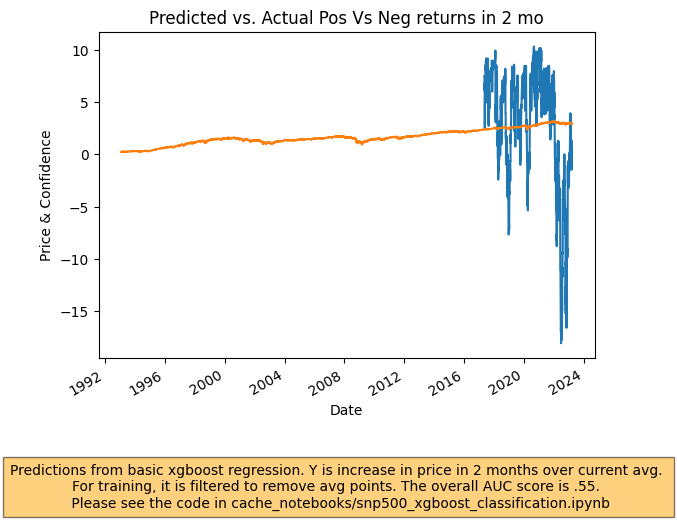

In [77]:
#plot exp_preds as a function of time
plt.plot(test_dates,test_pred)
#plot dataset with adjusted close
#dataset['Adj Close'].plot()
#plot the log of the adjusted close
(np.log(dataset['Adj Close'])-3).plot()
plt.title('Predicted vs. Actual Pos Vs Neg returns in 2 mo')
plt.xlabel('Date')
plt.ylabel('Price & Confidence')
#add caption below plot
text = "Predictions from basic xgboost regression. Y is increase in price in 2 months over current avg. \n"+\
        "For training, it is filtered to remove avg points. The overall AUC score is .55. \n Please see the code in cache_notebooks/snp500_xgboost_classification.ipynb"
plt.figtext(0.5, -0.11, text, ha='center', fontsize=10, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

#save plot to cache_notebooks/snp500_xgboost_classification.ipynb
#plt.savefig('../graph_results/snp500_xgboost_classification.png', bbox_inches='tight')

In [80]:
dates_in_pos_mo = []
for i in test_dates[test_pred > threshold]:
    for j in pd.date_range(i, periods=60, freq='D'):
        if (j not in dates_in_pos_mo):
            dates_in_pos_mo.append(j)
dates_in_pos_mo = [i for i in dates_in_pos_mo if i in test_dates]

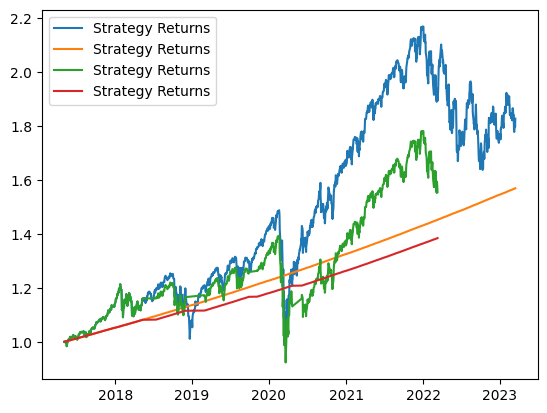

In [81]:
#plot the strategy returns and pct_returns
plt.plot(test_dates, (1+pct_returns_test).cumprod(), label='Strategy Returns')
plt.plot(test_dates, np.array(([1.0003054] * len(test_dates))).cumprod(), label='Strategy Returns')
plt.plot(dates_in_pos_mo, (1+pct_returns_test[test_dates.isin(dates_in_pos_mo)]).cumprod(), label='Strategy Returns')
plt.plot(dates_in_pos_mo, np.array(([1.0003054] * len(dates_in_pos_mo))).cumprod(), label='Strategy Returns')

#plt.plot(dates[:int(.8*len(dates))], (1+np.array(pct_returns)).cumprod(), label='S&P500 Returns')
plt.legend()